##### Установка сторонних модулей через pip

In [11]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics import roc_auc_score

### Подготовка данных

##### Получение данных для анализа

In [12]:
PATH_DATA = './data/data_part.json'
#PATH_DATA = './data/data.json'
PATH_MODEL = './data/model__kmeans'


dataRead = []
with open(PATH_DATA, 'r', encoding='utf-8') as jsonfile:    
    dataRead = json.load(jsonfile)
    
data = pd.DataFrame(data=dataRead)
data.head()

,Unknown,Skilled,Advertising,Clip,Videoshooting,Model,TVShow,Photoshooting,Text
0,1,0,0,0,0,0,0,0,мужчин актер съемок клип съемк клип ищ геро му...
1,1,0,0,0,0,0,0,0,вниман москв т взлет ориентировочн девушк лет ...
2,1,0,0,0,0,0,0,0,х ф данил козловск пада аист мужчин лет рост р...
3,1,0,0,0,0,0,0,0,нов шанс попаст кастинг супер телевикторин уга...
4,1,0,0,0,0,0,0,0,кастинг июл девушек размер одежд парн работ ию...


##### Получение целевого признака data_y

In [13]:
columns = 'TVShow'
data_y = data[columns]
data_y.value_counts()

0    96
1     4
Name: TVShow, dtype: int64

##### Получение данных для обучения data_x

In [14]:
data_x = data['Text']
data_x.shape

(100,)

##### Преобразование текста CountVectorizer

In [15]:
model_vectorizer = CountVectorizer()
vectorizer = model_vectorizer.fit(data_x)
feature_names = model_vectorizer.get_feature_names()

In [16]:
data_x = pd.DataFrame(data=vectorizer.transform(data_x).toarray(), columns=feature_names)
data_x.shape, len(feature_names)

((100, 1399), 1399)

In [17]:
data_x.head()

,абзац,абитуриент,авг,август,автомоб,автомобил,автомобильн,авторитет,агентск,агентств,...,явл,явля,явн,ягодиц,язвительн,язык,япон,ярк,яхт,ящик
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Кластеризация методом $k$ средних с преобразование текста CountVectorizer

In [18]:
COUNT_CLASTERS = 12
km = KMeans(n_clusters=COUNT_CLASTERS, init='k-means++', max_iter=100, n_init=1, n_jobs=8, verbose=1)

In [19]:
%%time
km.fit(data_x)

CPU times: user 22.5 ms, sys: 75 ms, total: 97.5 ms
Wall time: 1.12 s


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=12, n_init=1, n_jobs=8, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=1)

##### Выведем слова, соответствующие самым весомым компонентам центров кластеров

In [20]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(COUNT_CLASTERS):
    print("Cluster %d:" % (i + 1), end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % feature_names[ind], end='')
    print()

Cluster 1: лет нужн сь рол возраст сентябр квартир заявк клип молод
Cluster 2: фот лет почт съемк москв девушк внешност ваш заявк виде
Cluster 3: рост лет рол гонорар руб девушк письм внешност телефон заявк
Cluster 4: участ эт мужчин свободн девушк шо участник солидн путешеств русоволос
Cluster 5: месяц блогер курс ведущ практик тв старт сентябр телерадиоведущ мест
Cluster 6: смен дни горничн обязательн имет съемочн фот визитк виде тем
Cluster 7: фот рост заявк модел одежд сентябр оплат длин размер возраст
Cluster 8: сь девушк размер рост ищ музыкальн волос писа телеграмм образ
Cluster 9: девушк шо лет сезон нов зны дут ьбу рост телефон
Cluster 10: зап ден баз актер сь кастинг проект котор проезд войковск
Cluster 11: сь мочн снима сбор сентябр ден тем москв дни рассматрива
Cluster 12: работ июл оп мужчин ссылк съемк клип заявк смен будут


##### Визуализация с PCA

Text(0.5, 1.0, 'PCA')

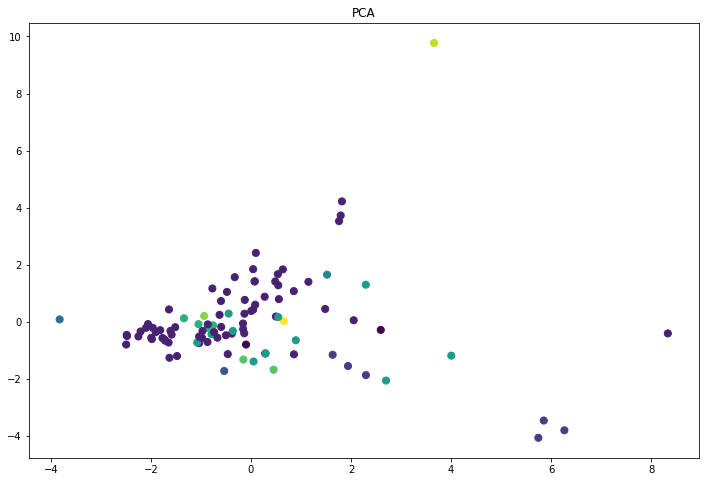

In [21]:
pca = PCA(n_components=2)
res = pca.fit_transform(data_x)
plt.figure(figsize=(12,8))
plt.scatter(res[:,0], res[:,1], c=km.labels_, s=50, cmap='viridis')
plt.title('PCA')

##### Понижение размерности с методом t-SNE

CPU times: user 730 ms, sys: 84.8 ms, total: 814 ms
Wall time: 469 ms


Text(0.5, 1.0, 'MNIST. t-SNE projection')

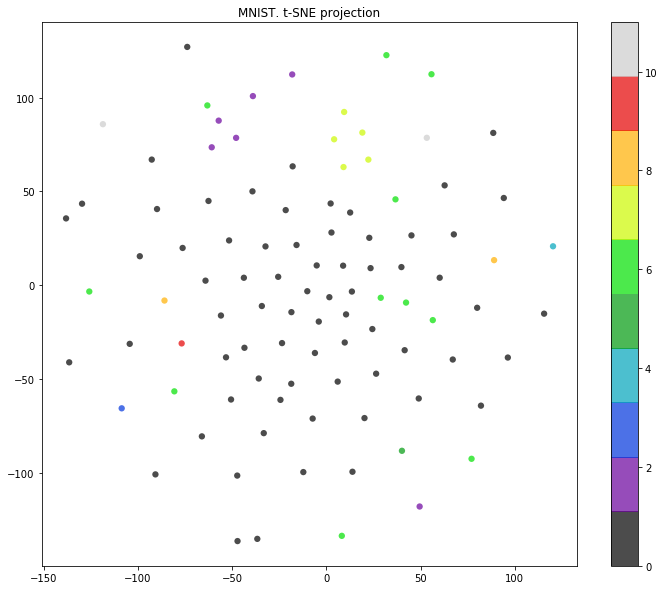

In [22]:
%%time
tsne = TSNE(random_state=17)
X_tsne = tsne.fit_transform(data_x)
plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=km.labels_, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection');

##### Подбор количества кластеров

In [23]:
%%time
MAX_COUNT_CLASTERS = 100
inertia = []
for k in range(1, MAX_COUNT_CLASTERS):
    kmeans = KMeans(n_clusters=k, random_state=17, n_jobs=8).fit(data_x)
    inertia.append(np.sqrt(kmeans.inertia_))

CPU times: user 1.41 s, sys: 374 ms, total: 1.78 s
Wall time: 21 s


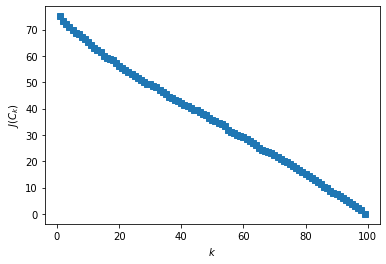

In [24]:
plt.plot(range(1, MAX_COUNT_CLASTERS), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

### Иерархическая кластеризация

In [25]:
mergings = linkage(data_x, method='complete')

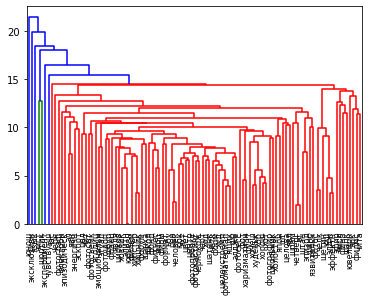

<Figure size 360x720 with 0 Axes>

In [26]:
dendrogram(mergings,
           labels=feature_names,
           leaf_rotation=90,
           leaf_font_size=8,
           )
plt.figure(figsize=(5, 10))
plt.show()
